# Descartes Underwritting: Technical test

Index: 
1. Introduction
1. Exploratory Data Analysis
2. Feature Engineering 
3. Modelling with LogisticRegression
4. Modelling with Random Forest
5. Modelling with XgBoost
6. Feature Importance Analysis
7. Predicting the test set with the best model
8. Conclusion






In [2]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 422 kB/s 


In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for EDA
import missingno as msno # for missing values
from sklearn.compose import make_column_selector as selector

#for feature eng...
import category_encoders as ce


#For prediction
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV

#Metrics
from scipy import interp
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support


import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.set_option('display.max_columns', None)

## Introduction

In this notebook we will explore the dataset proposed, after we will train three models to predict the TARGET_FLAG variable. Due to lack of context, we will infer the meaning of each variable and comment what is possible.

First, we read the train and test set and we create a dataframe.

In [3]:
train = pd.read_csv("https://raw.githubusercontent.com/descartes-underwriting/"
                    "data-scientist-technical-test/main/data/auto-insurance-fall-2017/train_auto.csv",
                    index_col="INDEX")
test = pd.read_csv("https://raw.githubusercontent.com/descartes-underwriting/"
                   "data-scientist-technical-test/main/data/auto-insurance-fall-2017/test_auto.csv",
                   index_col="INDEX")

In [4]:
X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
X_test, y_test =  test.iloc[:, 1:], test.iloc[:, 0]

### 2. Exploratory Data Analysis

Exploratory data analysis is the first step in every data science project. This step will help us perform initial investigation on the data so we can discover patterns, spot anomalies, test hypothesis and transform data. There is no strict rules for this step, in our case we will work as follows:

1.   Types of variables and questions.
2.   Variation.
3.   Missing values.
4.   Covariation.



It is important to mention that we analyze the train set and will apply all the modification made in the train test to the test set.



### 2.1 Types of variables and questions

We will check if every feature has the corresponding type of variable, since the type object in python can represent string, dates, etc.

In [5]:
pd.concat([X_train.dtypes, X_train.iloc[0], X_train.iloc[666]], axis=1)

,0,1,840
TARGET_AMT,float64,0,2697
KIDSDRIV,int64,0,2
AGE,float64,60,45
HOMEKIDS,int64,0,3
YOJ,float64,11,9
INCOME,object,"$67,349","$44,786"
PARENT1,object,No,No
HOME_VAL,object,$0,"$175,534"
MSTATUS,object,z_No,Yes
SEX,object,M,z_F


We can observe that the features *income, home_val, bluebook, oldclaim* represent an amount of money, so they should be represented as a continuous variables (float64). On the other hand, it is better to represent the feature *age* as integer. The remaining object features will be considered as categorical variables.

Features: *income, home_val, bluebook, old_claim*, we will delete the "$" sign and cast them to float64.

In [6]:
for col in ["INCOME", "HOME_VAL", "BLUEBOOK", "OLDCLAIM"]:
  X_train[col] = X_train[col].apply(lambda x: str(x).replace('$','').replace(',', '')).astype("float")
  X_test[col] = X_test[col].apply(lambda x: str(x).replace('$','').replace(',', '')).astype("float")

Feature: Age

In [7]:
X_train["AGE"] = X_train["AGE"].astype('int', errors='ignore')
X_test["AGE"] = X_test["AGE"].astype('int', errors='ignore')

Categorical features

In [8]:
categorical_variables_selector = selector(dtype_include=object)
categorical_variables = categorical_variables_selector(X_train)

for cat_feature in categorical_variables:
  X_train[cat_feature] = X_train[cat_feature].astype('category')
  X_test[cat_feature] = X_test[cat_feature].astype('category')

Now, we proceed to check the type of our target variable, so we can know if we are dealing with a regression or classification task.

In [9]:
print("Type assigned by pandas:", y_train.dtypes)
print("Unique values of the target variable:", y_train.unique())

Type assigned by pandas: int64
Unique values of the target variable: [0 1]


Clearly, we are dealing with a binary classification task. The feature TARGET_AMT is confusing since its name indicates that it may be a target to predict. To clear up any doubt, we check if it has values in the X_test.

In [10]:
X_test["TARGET_AMT"]

INDEX
3       NaN
9       NaN
10      NaN
18      NaN
21      NaN
         ..
10279   NaN
10281   NaN
10285   NaN
10294   NaN
10300   NaN
Name: TARGET_AMT, Length: 2141, dtype: float64

So clearly it is another target to predict. Following the instructions we drop this variable from both X_train and X_test and we continue our work.

In [11]:
X_train.drop("TARGET_AMT", axis=1, inplace=True)
X_test.drop("TARGET_AMT",axis=1, inplace=True)

Now we will look at a summary of each feature so we can have an idea of the distributions.

In [12]:
pd.concat([y_train.describe(), X_train.describe()], axis=1)


,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CAR_AGE
count,8161.000000,8161.000000,8155.000000,8161.000000,7707.000000,7716.000000,7697.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,7651.000000
mean,0.263816,0.171057,44.790313,0.721235,10.499286,61898.094609,154867.289723,33.485725,15709.899522,5.351305,4037.076216,0.798554,1.695503,8.328323
std,0.440728,0.511534,8.627589,1.116323,4.092474,47572.682808,129123.774574,15.908333,8419.734075,4.146635,8777.139104,1.158453,2.147112,5.700742
min,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1500.000000,1.000000,0.000000,0.000000,0.000000,-3.000000
25%,0.000000,0.000000,39.000000,0.000000,9.000000,28097.000000,0.000000,22.000000,9280.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,45.000000,0.000000,11.000000,54028.000000,161160.000000,33.000000,14440.000000,4.000000,0.000000,0.000000,1.000000,8.000000
75%,1.000000,0.000000,51.000000,1.000000,13.000000,85986.000000,238724.000000,44.000000,20850.000000,7.000000,4636.000000,2.000000,3.000000,12.000000
max,1.000000,4.000000,81.000000,5.000000,23.000000,367030.000000,885282.000000,142.000000,69740.000000,25.000000,57037.000000,5.000000,13.000000,28.000000


Here we include some interesting comments:

*   Only 25 % of the population have value 1 for the target.
*   Some variables have outliers, we will confirm that later on.
*   Car age seems to have values which are wrong since the minimum is -3 (not valid for a feature like age of something).

We will have a better insight into the dataset if we plot the distributions of each feature and the target variable.


We set to zero the CAR_AGE value of the sample with value -3.

In [13]:
idx_wrong_value = X_train["CAR_AGE"].loc[X_train["CAR_AGE"] < 0].index
X_train.loc[idx_wrong_value, "CAR_AGE"] = 0

In [14]:
X_train["CAR_AGE"].loc[X_train["CAR_AGE"] < 0].index

Int64Index([], dtype='int64', name='INDEX')

### 2.2 Variation

Variation is the tendency of the values of a variable to change from measurement to measurement.

Distribution of the categorical variables.

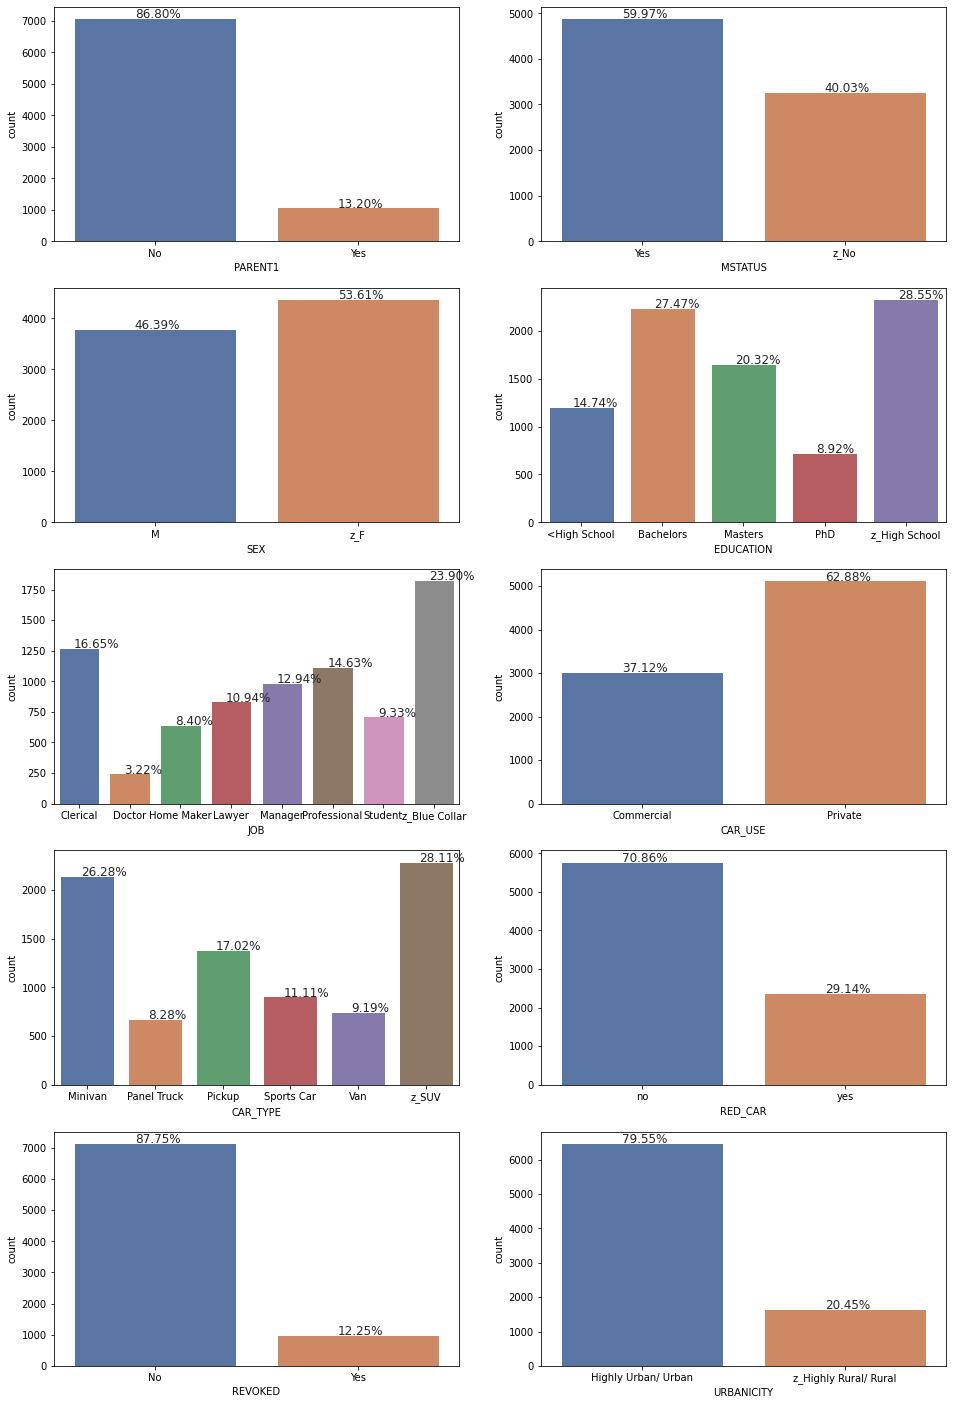

In [15]:
nb_subplots = int(len(categorical_variables) / 2) if len(categorical_variables) % 2 == 0 else int(len(categorical_variables) / 2) + 1 
fig, axes = plt.subplots(nb_subplots, 2, figsize=(16, 25))


for ax, cat_variable in zip(axes.flatten(), categorical_variables):
  sns.set_theme(style="darkgrid") 
  ax = sns.countplot(x=cat_variable, data=X_train, ax=ax)

  #total = ax.patches.get_height().sum()
  total = sum([p.get_height() for p in ax.patches])
  
  for p in ax.patches:
    ax.annotate('{:.2f}%'.format((p.get_height()/total)*100), (p.get_x()+0.3, p.get_height()+2))
  

We clearly observe:

*   The 86.8 % of our population is not a single parent (feature PARENT1).
*   We have more data about married people.
*   The 62.88 % of the cars are for private use.
*   The 87.75 % of the population did not revoke their previous claims.
*   Almost 80 % of people live in Highly Urban or Urban area. 

We will check the relationship of these variables with the target variable in the Covariation section.


Distribution of the continuous variables

In [16]:
numerical_variables_selector = selector(dtype_exclude='category')
numerical_variables = numerical_variables_selector(X_train)

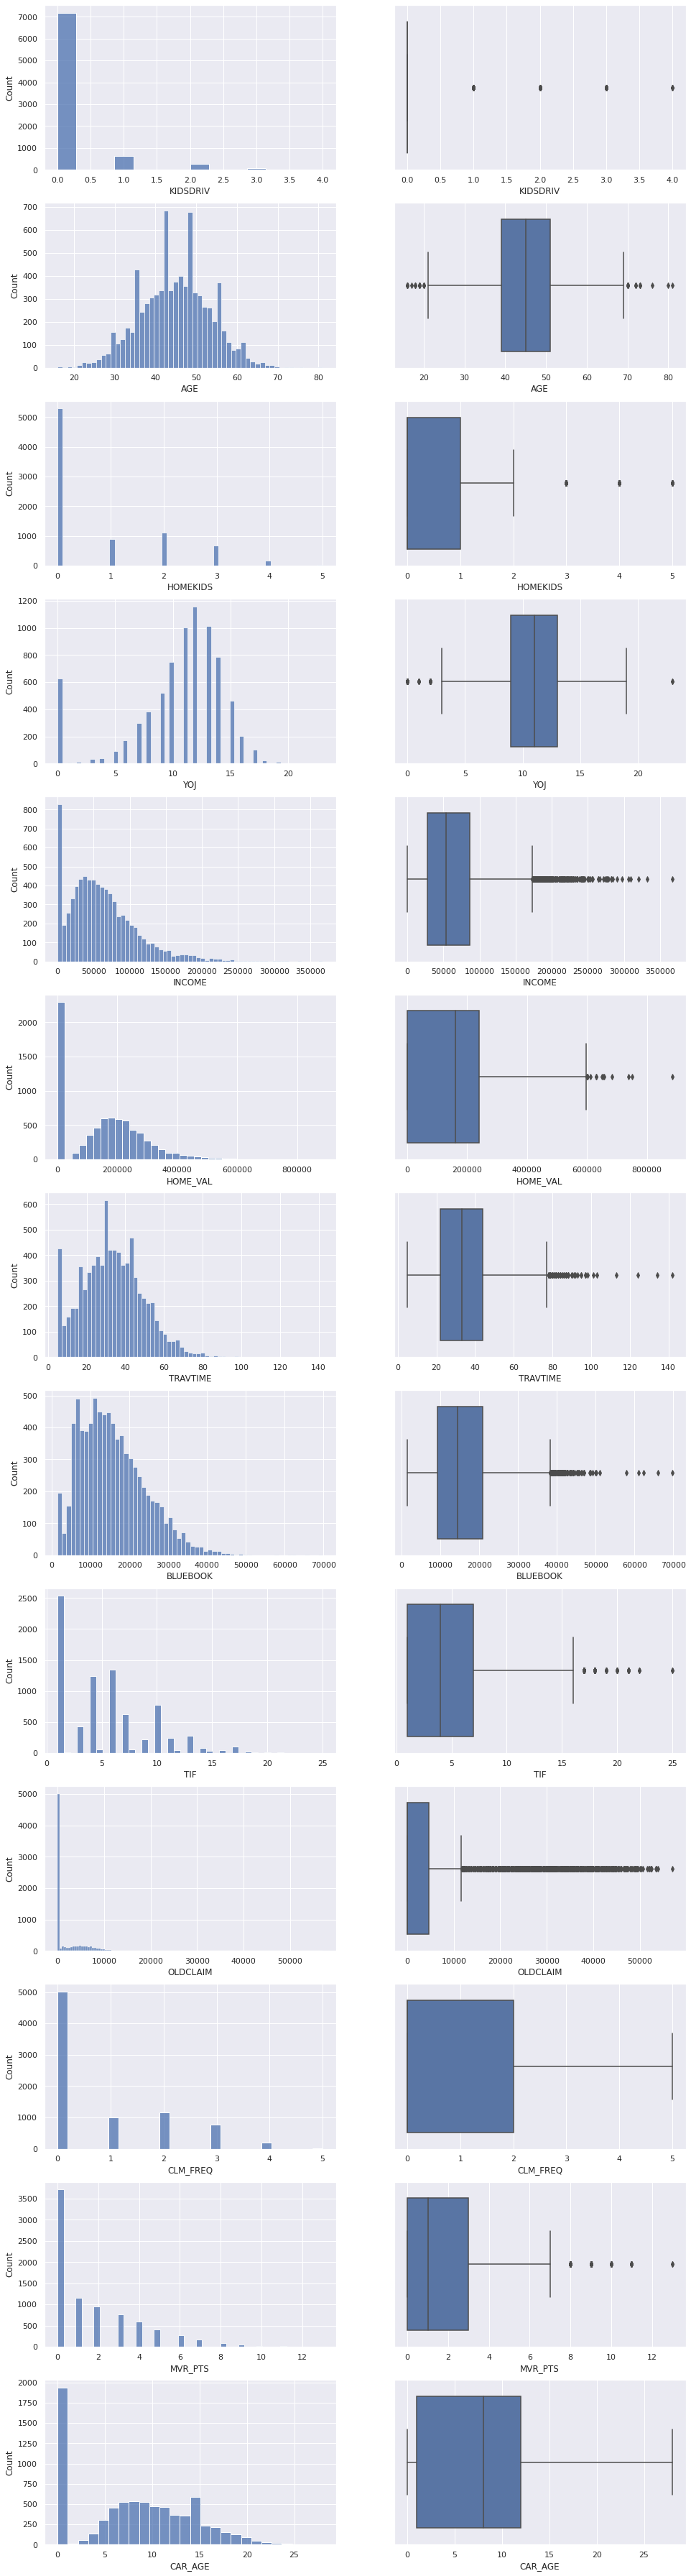

In [17]:
nb_subplots = int(len(numerical_variables) )  
fig, axes = plt.subplots(nb_subplots, 2, figsize=(16, 5*nb_subplots))

for ax, num_variable in zip(axes, numerical_variables):
  sns.set_theme(style="darkgrid")
  sns.histplot(x=num_variable, data=X_train, ax=ax[0])
  sns.boxplot(x=num_variable, data=X_train, ax=ax[1])

plt.show()


Many of the numerical variables follow a normal distribution. However, others, like KIDSDRIV, are higly skewed. We will compute the skewness of the distributions in order to apply the adecuate transformation which will benefit the predictions.

On the other hand, we confirm that some features have outliers. Depending on the model we will choose for the prediction we will see whether we need to treat them or not.

We compute the skewness.

In [18]:
feat_skewness = X_train[numerical_variables].skew()
print(feat_skewness)

KIDSDRIV    3.353070
AGE        -0.029000
HOMEKIDS    1.341620
YOJ        -1.203436
INCOME      1.186778
HOME_VAL    0.488785
TRAVTIME    0.446982
BLUEBOOK    0.794506
TIF         0.891140
OLDCLAIM    3.120187
CLM_FREQ    1.209243
MVR_PTS     1.348336
CAR_AGE     0.282576
dtype: float64


Values above 1 or -1 indicates highly skewed distributions and values between -1 and -0.5 or 1 and 0.5 indicate moderately skewed distributions. Thus, we will differentiate between highly and moderately skewed distributions of the features so we can apply distinctive transformation later on.

In [19]:
neg_highly_skew_feat = feat_skewness.loc[feat_skewness < -1].index
pos_highly_skew_feat = feat_skewness.loc[feat_skewness > 1].index
moderate_skew_feat = feat_skewness.loc[abs(feat_skewness) <= 1].index & feat_skewness.loc[abs(feat_skewness) > 0.5].index 

Now we plot the distribution of the target.

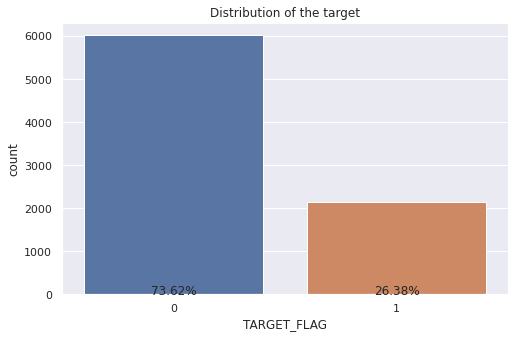

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax = sns.countplot(y_train, ax=ax)


for p in ax.patches:
  ax.annotate('{:.2f}%'.format(((p.get_height())/y_train.shape[0])*100), (p.get_x() + 0.3, p.get_y() ))
plt.title("Distribution of the target")
plt.show()

It is clearly that we have an imbalanced dataset but it is so common in this type of problems. We will not try any sampling method to correct this until we oberve that the model chosen can't predict the minority class. 

### 2.3 Missing values

We will check if there is missing values in the features. To do so, we will use isnull function of pandas but we will check also the unique values of each categorical features just to make sure that we considered all the missing values. 

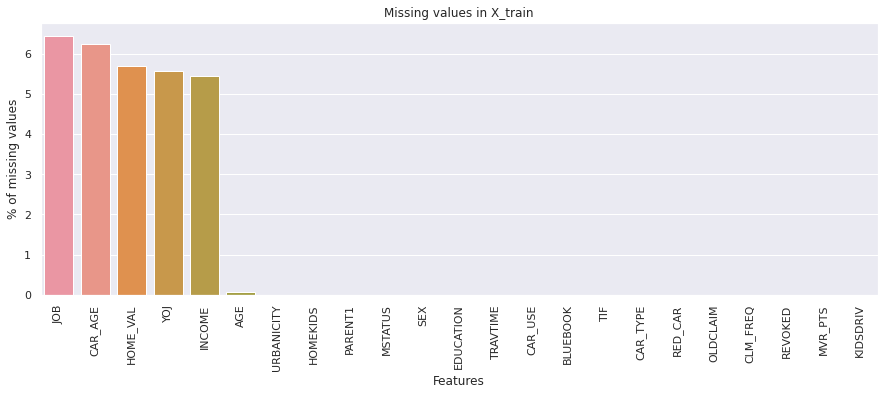

In [22]:
nb_samples = X_train.shape[0]
nan_values = X_train.isnull().sum().sort_values(ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.barplot(x=nan_values.index, y=(nan_values.values/nb_samples)*100, ax=ax)
plt.xticks(rotation=90)
ax.set_xlabel("Features")
ax.set_ylabel("% of missing values")
plt.title("Missing values in X_train")
plt.show()

JOB, CAR_AGE, HOME_VAL, YOJ, INCOME and AGE have missing values. Before applying any imputation technique, we will analyze if the missing values are MCAR (missing completely at random), MAR (missing at random) or MNAR (missing not at random) because the distribution of the missing values can give us an insight about the data and determines which type of imputation technique we should use. To do so, we will use Missingno package to plot the distribution of the missing values and the correlation between them.

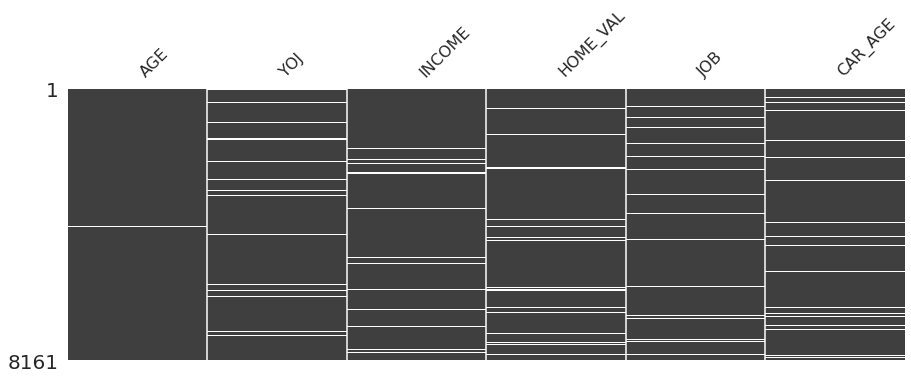

In [23]:
feat_with_nan = X_train.isnull().sum().loc[X_train.isnull().sum() > 0].index

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
msno.matrix(X_train[feat_with_nan], ax=ax)
plt.show()

We can clearly deduce that almost all the missing values are randomly scaterred. Now, we plot the correlation matrix.

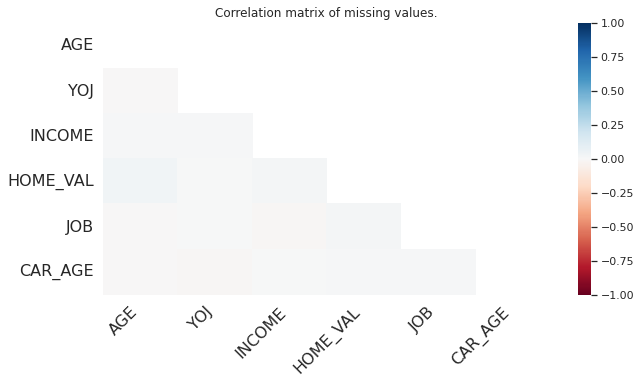

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
msno.heatmap(X_train, ax=ax)
plt.title("Correlation matrix of missing values.")
plt.show()

There is little to nothing correlation between the missing values of the features, we can prefectly conclude that the features have missing values completely at random.

There are several imputation methods for missing values, we will only try the basic ones (following the instructions):

1.   Droping rows.
2.   Imputation with a constant value.
3.   Imputation with statistics (mean, median, mode, etc.)
4.   Imputation with K-Nearest neighbors.



Droping values: we will check how many samples we are left with after droping all the rows with missing values.

In [30]:
print("Number of samples keeping missing values:", X_train.shape[0])
print("Number of samples after droping missing values:", X_train.dropna().shape[0])
print("Percentage of data dropped:", (1 - (X_train.dropna().shape[0] / X_train.shape[0])) * 100, " %")

Number of samples keeping missing values: 8161
Number of samples after droping missing values: 6045
Percentage of data dropped: 25.928195074133075  %


If we drop the missing values rows, we will be droping approximately 26 % of the samples, bearing in mind that more the samples better the results, we will not consider this technique of imputation.

Only one categorical feature has missing values. Since there is no relationship between missing values of this feature and the rest of features, we will replace the missing values with a new value "Unknown". 

In [31]:
 X_train["JOB"] = X_train["JOB"].cat.add_categories("Unknown").fillna("Unknown")
 X_test["JOB"] = X_test["JOB"].cat.add_categories("Unknown").fillna("Unknown")

Due to the fact that our missing values are MCAR, the imputation with statistics works well. However, there are some limitations like the distortion of the original variance and the distorition of covariance with the remaining variables within the dataset. We will not handle this since the performance is not the goal of this project.

In [26]:
X_train.fillna(X_train.median(), inplace=True)
X_test.fillna(X_train.median(), inplace=True) 

### 2.4 Covariation

Behaviour between categorical variables and the target.

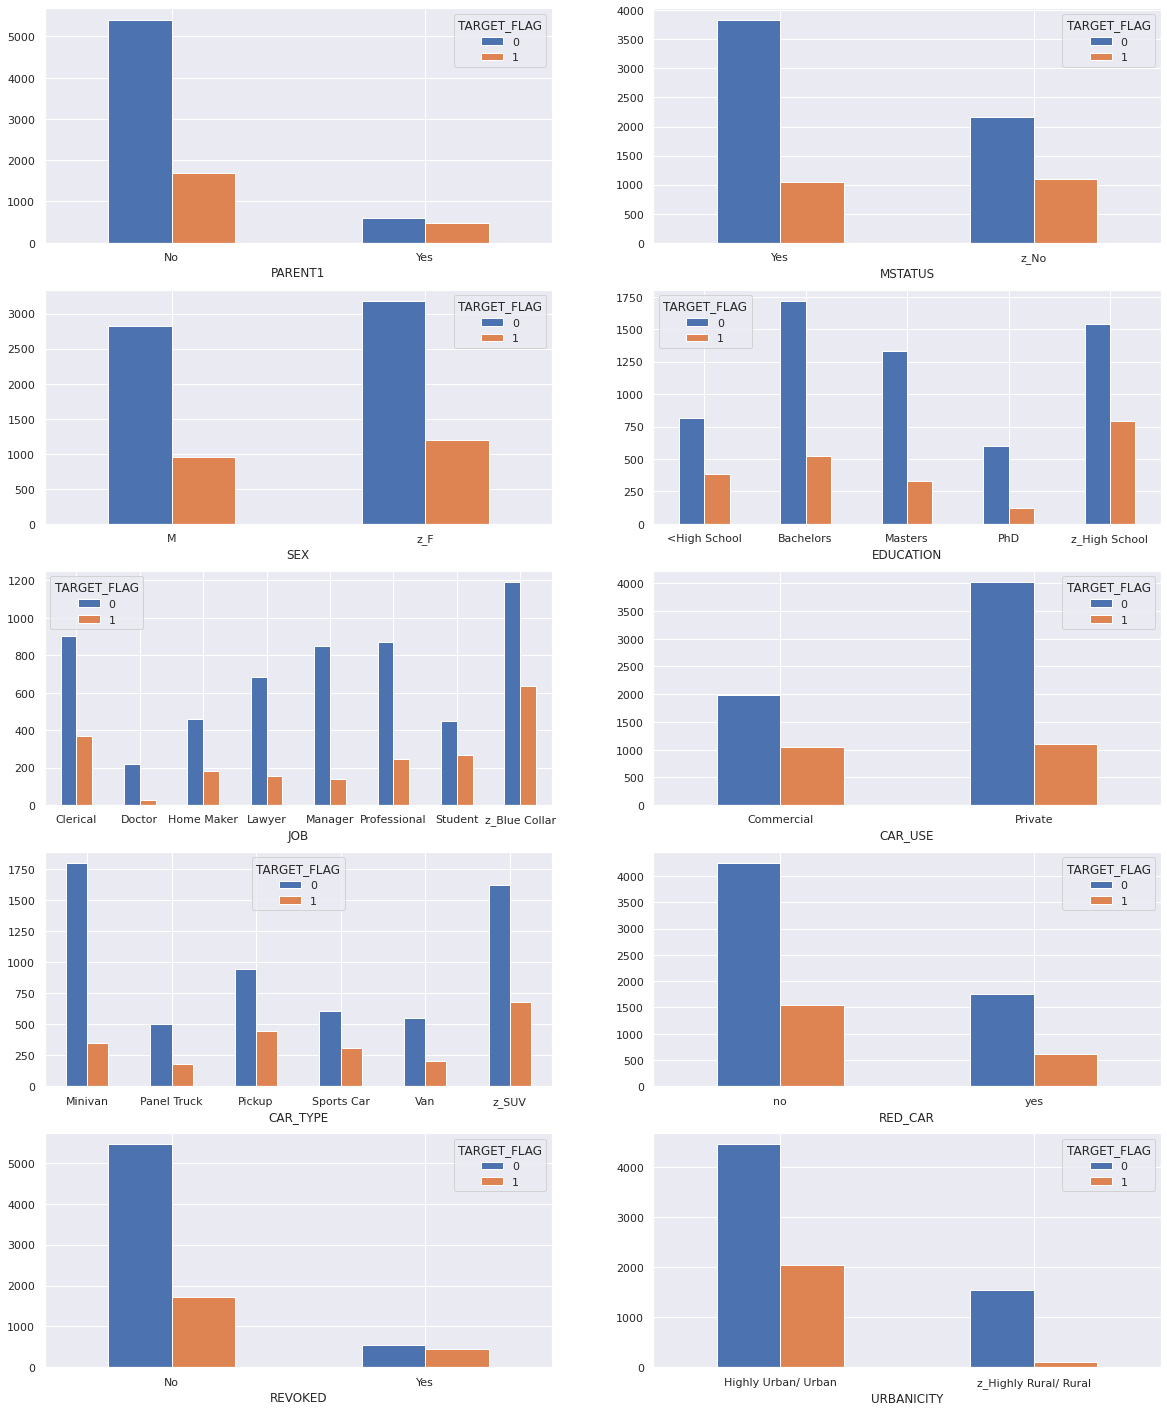

In [27]:
nb_subplots = int(len(categorical_variables) / 2) if len(categorical_variables) % 2 == 0 else int(len(categorical_variables) / 2) + 1
fig, axes = plt.subplots(nb_subplots, 2, figsize=(20, 5 * nb_subplots))

for col, ax in zip(categorical_variables, axes.flatten()):
  
  cross_tab = pd.crosstab(X_train[col], y_train)
  cross_tab.plot.bar(ax=ax)
  ax.set_xticklabels(cross_tab.index, rotation = 0)
  

plt.show()

Almost all the grouped bars are of different length for each category, then the variables are correlated to the target variable.


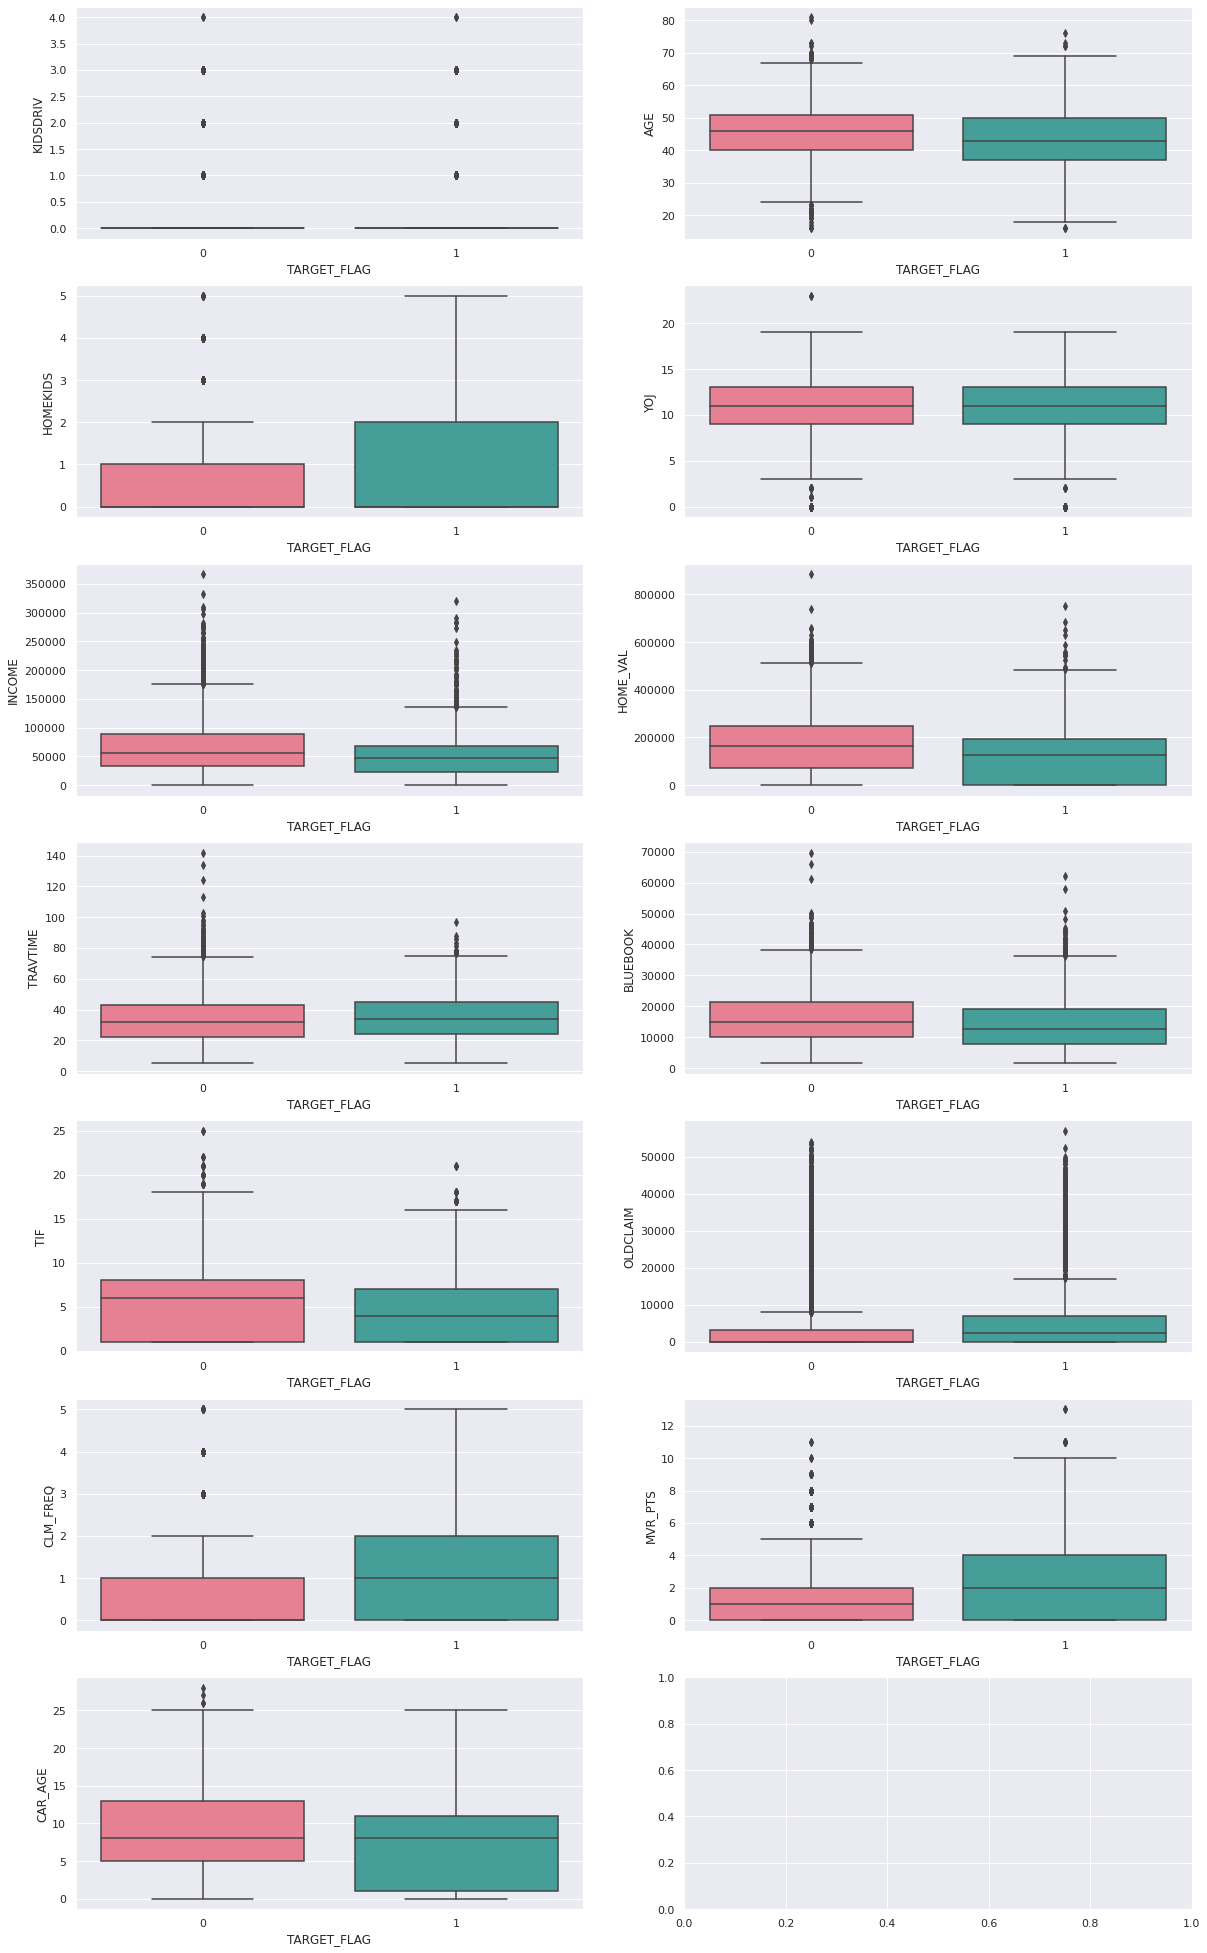

In [28]:
nb_subplots = int(len(numerical_variables) / 2) if len(numerical_variables) % 2 == 0 else int(len(numerical_variables) / 2) + 1 
fig, axes = plt.subplots(nb_subplots, 2, figsize=(20, 5 * nb_subplots))

for col, ax in zip(numerical_variables, axes.flatten()):
  sns.set_theme(style="darkgrid")
  sns.boxplot(x=y_train, y=col, data=X_train, ax=ax, palette="husl")

plt.show()

From the above boxplots we note the following:

*   KIDSDRIVE has no relationship with the target.
*   AGE has a weak relathionship with the target, showing that the ones with a lower age are on average with value 1 of the target.
*   YOJ also has a weak relathionship woth the target.
*   The lower the income, the more likely to have value 1 of the target.
*   BLUEBOOK appears to have a weak relathionship with the target too, the lower the value, the more likely to have value 1 of the target.
*   TIF show the same behaviour as the previous variable with the target.
*   Those who have higher claim values are more likely to have value 1 of the target.
*   CLM_FREQ appears to have more relationship with the target.
*   MVR_PTS and CAR_AGE show also a strong relathionship with the target.


The features that we did not mention appear to have no relathionship with the target.



Correlation matrix

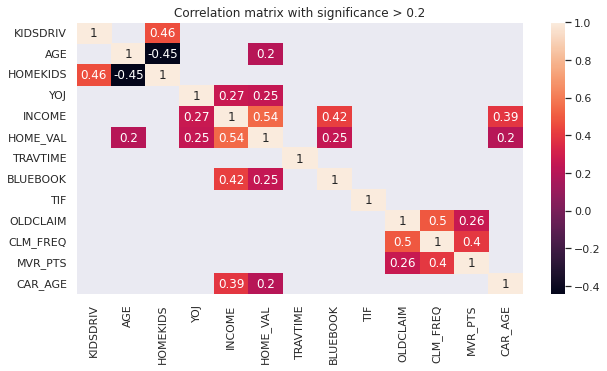

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.heatmap(X_train.corr().where(abs(X_train.corr()) > 0.2, np.nan), annot=True, ax=ax) #only the superior part
ax.set_title("Correlation matrix with significance > 0.2")
plt.show()

We computed the correlation between variables to check if there is a strong colinearity between some variables since it is important to remove it in order to use some models. From the plot above we observe that there is barely colinearity between the variables except for OLDCLAIM and CLM_FREQ, INCOME and HOME_VAL, HOMEKIDS and KIDSDRIV, AGE and HOMEKIDS. But we will not drop any of the columns due to the fact that there the values computed are not high.

### Feature Engineering

This is another important step in every data science project. This process consists in creating new features from the existing features, transforming the existing features. 

Continous variables: 

*   Negativly highly skewed data will be transformed using square transformation $x^2$.
*   Positivly highly skewed data will be transformed using $log( x  + 1)$ as zero is a possible value of our features.
*  As shown above, most our features have outliers, so for the not transformed variables we will opt for a Standarization.



In [30]:
X_train[neg_highly_skew_feat] = X_train[neg_highly_skew_feat].pow(2)
X_test[neg_highly_skew_feat] = X_test[neg_highly_skew_feat].pow(2)

In [31]:
X_train[pos_highly_skew_feat] = np.log(X_train[pos_highly_skew_feat] + 1)
X_test[pos_highly_skew_feat] = np.log(X_test[pos_highly_skew_feat] + 1)

In [32]:
remaining_feat = []
for col in X_train.columns: #we ignore missing values
  if (col not in pos_highly_skew_feat) and (col not in neg_highly_skew_feat) and (col not in categorical_variables):
    remaining_feat.append(col)


mean_train = X_train[remaining_feat].mean()
std_train = X_train[remaining_feat].std()

X_train[remaining_feat] = (X_train[remaining_feat] - mean_train) / std_train
X_test[remaining_feat] = (X_test[remaining_feat] - mean_train) / std_train


Since we don't have a whole description of the variables and from the deduced meaning, we assume there are no ordinal variables, i.e. there is no inherent order we need to take into account. So we will treat all the categorical variables as nominal variables. First we will check the number of categories of each feature in order to choose a good encoding technique and avoid having a sparse matrix that might affect negatively the predictions.

In [33]:
for i, col in enumerate(categorical_variables):
  print("The feature ", i, "-", col, " has ", len(X_train[col].unique()), " categories: ", X_train[col].cat.categories.values)



The feature  0 - PARENT1  has  2  categories:  ['No' 'Yes']
The feature  1 - MSTATUS  has  2  categories:  ['Yes' 'z_No']
The feature  2 - SEX  has  2  categories:  ['M' 'z_F']
The feature  3 - EDUCATION  has  5  categories:  ['<High School' 'Bachelors' 'Masters' 'PhD' 'z_High School']
The feature  4 - JOB  has  9  categories:  ['Clerical' 'Doctor' 'Home Maker' 'Lawyer' 'Manager' 'Professional'
 'Student' 'z_Blue Collar']
The feature  5 - CAR_USE  has  2  categories:  ['Commercial' 'Private']
The feature  6 - CAR_TYPE  has  6  categories:  ['Minivan' 'Panel Truck' 'Pickup' 'Sports Car' 'Van' 'z_SUV']
The feature  7 - RED_CAR  has  2  categories:  ['no' 'yes']
The feature  8 - REVOKED  has  2  categories:  ['No' 'Yes']
The feature  9 - URBANICITY  has  2  categories:  ['Highly Urban/ Urban' 'z_Highly Rural/ Rural']


In [34]:
one_hot_enc = ce.OneHotEncoder(cols=categorical_variables)
one_hot_enc.fit_transform(X_train).shape


(8161, 47)

We can observe that most of the categorical variables are binary but we have three features(EDUCATION, JOB, CAR_TYPE) with more than 3 categories. If we use a simple encoder like One Hot Encoding, we will have 47 columns   columns with zeros and ones which creates a sparse matrix. So we will opt for a Binary Enconding for all the features. The latter still produces a sparse matrix but with lower dimensionality.

In [35]:
binary_enc = ce.BinaryEncoder(cols=categorical_variables)
X_train = binary_enc.fit_transform(X_train)
X_test = binary_enc.transform(X_test)

In [36]:
X_train.shape

(8161, 37)

## Models

In this section we will train and evaluate three models. We are dealing with a binary classification task, we aim not only to predict right the target but also to explain which variables are the most important and impact the results. We are trying to achieve a tradeoff between good prediction and interpretability. Bearing in mind the latter, we will not train a neural network in spite of its known good performance in many problems.

We enumerate the problems of our data set:


*   Presence of outliers in so many variables.
*   We tried to reduce the dimensionality by using a good encoder, even though we still have a sparse matrix.  This issue may lead to overfitting, so we need to be careful. Thus, we need models that can handle this.
*  Imbanlanced dataset.




 Given the arguments and issues, we choose Logistic Regression since it is the classic model and can be used as a benchmark (in spite of not being good with categorical variables), (we assume that the data meets all the assumptions). On the other hand, we decided to train also a Random Forest, known for its robustness to outliers, good with categorical features, ability to compute the feature importance. Moreover, we opt also for training a Xgboost, due to its known outperformance in so many kaggle competition, robustness to outliers and ability to handle the categorical variables. 

 We think that a SVM classifier may be good but if the data is not linearly separable we cannot compute the features importance, so we don't train this model.



 For the training and evaluation, we choose a Stratified 5 Fold Cross validation, to make sure the folds are made by preserving the percentage of samples for each class.

 As mentioned above, we have an imbalanced dataset, the usual problem we can face in this case is that our model overfit to the majority class and not be able to learn how to predict the minority class. Therefore, the accuracy metric is misleading because it does not indicate if both classes were rightly learnt by the model. So, we will focus more in the sensitivity and specificity metrics. Sensitivity is the proportion of the positive samples which is well classified while specificity (also called true negative rate) is the proportion of the negative samples which are well classified. In this context, the value 0 (majority class) is the positive class.


 We also plot the ROC and compute the area under the curve AUC. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes.



### Modelling with Logistic Regression


                    1-Fold Train  1-Fold Test  2-Fold Train  2-Fold Test  \
Precision               0.808530     0.816312      0.811386     0.803493   
Sensitivity/recall      0.926966     0.924293      0.928215     0.918469   
Specificity             0.387340     0.419954      0.398143     0.372093   
F1-Score                0.863707     0.866953      0.865877     0.857143   
Accuracy                0.784620     0.791182      0.788329     0.774510   

                    3-Fold Train  3-Fold Test  4-Fold Train  4-Fold Test  \
Precision               0.812294     0.808715      0.808267     0.816932   
Sensitivity/recall      0.923845     0.910982      0.923445     0.940050   
Specificity             0.404527     0.397674      0.388502     0.412993   
F1-Score                0.864486     0.856808      0.862025     0.874177   
Accuracy                0.786797     0.775735      0.782356     0.800858   

                    5-Fold Train  5-Fold Test  Mean Test  Std Test  
Precision        

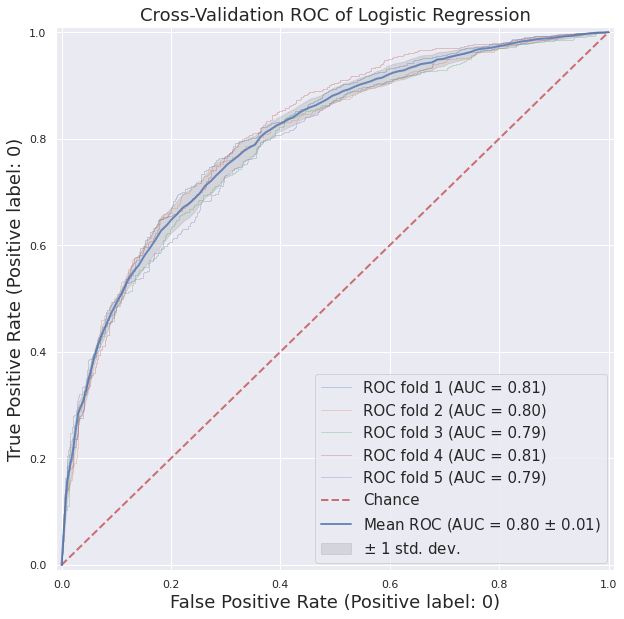

In [37]:
logi_reg = LogisticRegression(random_state=0)


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
metrics = ["Precision", "Sensitivity/recall", "Specificity", "F1-Score", "Accuracy"]
logi_reg_metrics = pd.DataFrame(index=metrics)
columns_test = []


#for roc
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))


for i, (idx_train, idx_test) in enumerate(skf.split(X_train, y_train)):
  X_train_fold, X_test_fold = X_train.iloc[idx_train], X_train.iloc[idx_test]
  y_train_fold, y_test_fold = y_train.iloc[idx_train], y_train.iloc[idx_test]

  logi_reg = logi_reg.fit(X_train_fold, y_train_fold)
  y_pred_fold = logi_reg.predict(X_test_fold)
  y_pred_train_fold = logi_reg.predict(X_train_fold)
  y_pred_prob_fold = logi_reg.predict_proba(X_test_fold)[:, 0] #order of classes 0 1

  results_test1 = list(precision_recall_fscore_support(y_test_fold, y_pred_fold, average='binary', pos_label=1))
  results_test0 = list(precision_recall_fscore_support(y_test_fold, y_pred_fold, average='binary', pos_label=0))

  results_train1 = list(precision_recall_fscore_support(y_train_fold, y_pred_train_fold, average='binary', pos_label=1))
  results_train0 = list(precision_recall_fscore_support(y_train_fold, y_pred_train_fold, average='binary', pos_label=0))

  logi_reg_metrics[str(i+1)+"-Fold Train"] = results_train0[:-2] + [results_train1[1]] + [results_train0[2]] + [accuracy_score(y_train_fold, y_pred_train_fold)]
  logi_reg_metrics[str(i+1)+"-Fold Test"] = results_test0[:-2] + [results_test1[1]] + [results_test0[2]] + [accuracy_score(y_test_fold, y_pred_fold)]
  columns_test.append(str(i+1)+"-Fold Test")
  


  #for roc
  fpr, tpr, thresholds = roc_curve(y_test_fold, y_pred_prob_fold, pos_label=0)
  tprs.append(interp(mean_fpr, fpr, tpr))
  tprs[-1][0] = 0.0
  roc_auc = auc(fpr, tpr)
  aucs.append(roc_auc)
  plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i + 1, roc_auc))


logi_reg_metrics["Mean Test"] = logi_reg_metrics.mean(axis=1)
logi_reg_metrics["Std Test"] = logi_reg_metrics.std(axis=1)

print(logi_reg_metrics)



#for roc
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate (Positive label: 0)',fontsize=18)
plt.ylabel('True Positive Rate (Positive label: 0)',fontsize=18)
plt.title('Cross-Validation ROC of Logistic Regression',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()




### Modelling with Random Forest

                    1-Fold Train  1-Fold Test  2-Fold Train  2-Fold Test  \
Precision               0.870997     0.810504      0.876311     0.800707   
Sensitivity/recall      0.990429     0.950083      0.990637     0.942596   
Specificity             0.590592     0.380510      0.609983     0.344186   
F1-Score                0.926882     0.874761      0.929974     0.865877   
Accuracy                0.884957     0.799755      0.890182     0.784926   

                    3-Fold Train  3-Fold Test  4-Fold Train  4-Fold Test  \
Precision               0.874540     0.800717      0.877690     0.811001   
Sensitivity/recall      0.989180     0.929285      0.992719     0.957535   
Specificity             0.604179     0.353488      0.613821     0.378190   
F1-Score                0.928334     0.860223      0.931667     0.878198   
Accuracy                0.887578     0.777574      0.892786     0.804534   

                    5-Fold Train  5-Fold Test  Mean Test  Std Test  
Precision        

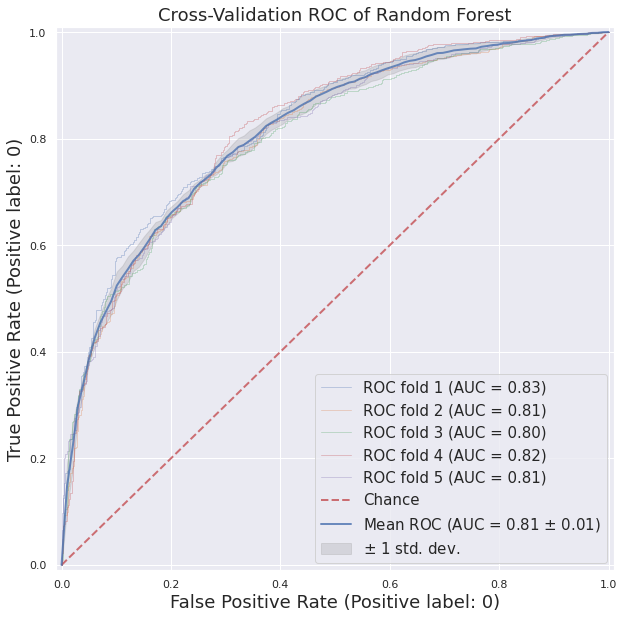

In [38]:
rf = RandomForestClassifier(max_depth=10, random_state=0)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

rf_metrics = pd.DataFrame(index=metrics)
columns_test = []


#for roc
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))

for i, (idx_train, idx_test) in enumerate(skf.split(X_train, y_train)):
  X_train_fold, X_test_fold = X_train.iloc[idx_train], X_train.iloc[idx_test]
  y_train_fold, y_test_fold = y_train.iloc[idx_train], y_train.iloc[idx_test]

  rf = rf.fit(X_train_fold, y_train_fold)
  y_pred_fold = rf.predict(X_test_fold)
  y_pred_train_fold = rf.predict(X_train_fold)
  y_pred_prob_fold = rf.predict_proba(X_test_fold)[:, 0] # order of classes 0 1

  results_test1 = list(precision_recall_fscore_support(y_test_fold, y_pred_fold, average='binary', pos_label=1))
  results_test0 = list(precision_recall_fscore_support(y_test_fold, y_pred_fold, average='binary', pos_label=0))

  results_train1 = list(precision_recall_fscore_support(y_train_fold, y_pred_train_fold, average='binary', pos_label=1))
  results_train0 = list(precision_recall_fscore_support(y_train_fold, y_pred_train_fold, average='binary', pos_label=0))

  rf_metrics[str(i+1)+"-Fold Train"] = results_train0[:-2] + [results_train1[1]] + [results_train0[2]] + [accuracy_score(y_train_fold, y_pred_train_fold)]
  rf_metrics[str(i+1)+"-Fold Test"] = results_test0[:-2] + [results_test1[1]] + [results_test0[2]] + [accuracy_score(y_test_fold, y_pred_fold)]
  columns_test.append(str(i+1)+"-Fold Test")

  #for roc
  fpr, tpr, thresholds = roc_curve(y_test_fold, y_pred_prob_fold, pos_label=0)
  tprs.append(interp(mean_fpr, fpr, tpr))
  tprs[-1][0] = 0.0
  roc_auc = auc(fpr, tpr)
  aucs.append(roc_auc)
  plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i + 1, roc_auc))



rf_metrics["Mean Test"] = rf_metrics[columns_test].mean(axis=1)
rf_metrics["Std Test"] = rf_metrics[columns_test].std(axis=1)

print(rf_metrics)



#for roc
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate (Positive label: 0)',fontsize=18)
plt.ylabel('True Positive Rate (Positive label: 0)',fontsize=18)
plt.title('Cross-Validation ROC of Random Forest',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()


### Modelling with XgBoost

                    1-Fold Train  1-Fold Test  2-Fold Train  2-Fold Test  \
Precision               0.806520     0.809084      0.808639     0.804982   
Sensitivity/recall      0.952351     0.948419      0.950479     0.940932   
Specificity             0.362369     0.375870      0.372606     0.362791   
F1-Score                0.873390     0.873229      0.873840     0.867664   
Accuracy                0.796722     0.797306      0.797978     0.788603   

                    3-Fold Train  3-Fold Test  4-Fold Train  4-Fold Test  \
Precision               0.812666     0.801576      0.808673     0.812678   
Sensitivity/recall      0.953184     0.930948      0.950489     0.950042   
Specificity             0.387115     0.355814      0.372242     0.389791   
F1-Score                0.877334     0.861432      0.873864     0.876008   
Accuracy                0.803798     0.779412      0.797978     0.802083   

                    5-Fold Train  5-Fold Test  Mean Test  Std Test  
Precision        

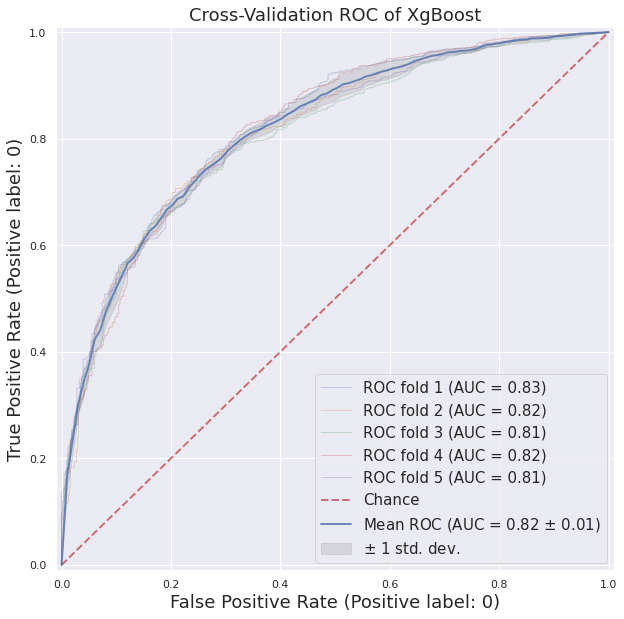

In [39]:
xgb = XGBClassifier(max_depth=2, random_state=0)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
xgb_metrics = pd.DataFrame(index=metrics)
columns_test = []

#for roc
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))

for i, (idx_train, idx_test) in enumerate(skf.split(X_train, y_train)):
  X_train_fold, X_test_fold = X_train.iloc[idx_train], X_train.iloc[idx_test]
  y_train_fold, y_test_fold = y_train.iloc[idx_train], y_train.iloc[idx_test]

  xgb = xgb.fit(X_train_fold, y_train_fold)
  y_pred_fold = xgb.predict(X_test_fold)
  y_pred_train_fold = xgb.predict(X_train_fold)
  y_pred_prob_fold = xgb.predict_proba(X_test_fold)[:, 0] #order of class 0 1


  results_test1 = list(precision_recall_fscore_support(y_test_fold, y_pred_fold, average='binary', pos_label=1))
  results_test0 = list(precision_recall_fscore_support(y_test_fold, y_pred_fold, average='binary', pos_label=0))

  results_train1 = list(precision_recall_fscore_support(y_train_fold, y_pred_train_fold, average='binary', pos_label=1))
  results_train0 = list(precision_recall_fscore_support(y_train_fold, y_pred_train_fold, average='binary', pos_label=0))

  xgb_metrics[str(i+1)+"-Fold Train"] = results_train0[:-2] + [results_train1[1]] + [results_train0[2]] + [accuracy_score(y_train_fold, y_pred_train_fold)]
  xgb_metrics[str(i+1)+"-Fold Test"] = results_test0[:-2] + [results_test1[1]] + [results_test0[2]] + [accuracy_score(y_test_fold, y_pred_fold)]
  columns_test.append(str(i+1)+"-Fold Test")

  #for roc
  fpr, tpr, thresholds = roc_curve(y_test_fold, y_pred_prob_fold, pos_label=0)
  tprs.append(interp(mean_fpr, fpr, tpr))
  tprs[-1][0] = 0.0
  roc_auc = auc(fpr, tpr)
  aucs.append(roc_auc)
  plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i + 1, roc_auc))

xgb_metrics["Mean Test"] = xgb_metrics.mean(axis=1)
xgb_metrics["Std Test"] = xgb_metrics.std(axis=1)


print(xgb_metrics)

#for roc
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate (Positive label: 0)',fontsize=18)
plt.ylabel('True Positive Rate (Positive label: 0)',fontsize=18)
plt.title('Cross-Validation ROC of XgBoost',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()


Discussion:

The majority and positive class is 0, we can conclude from the results that all the models chosen cannot predict well the minority class 1 since the value of the specificity is aproximetaly 0.35 in all the folds. 
We computed the metrics in the train set and test set so we can identify which model overfits. RandomForest seems to be the one overfitting, so we don't consider this one. Maybe if we had searched for the best parameters we would not face this problem.

As explained, the ROC and auc are indicators of the ability of the model to separate between the two classes. The values are not perfect but suprinsingly not bad either because it is not 0.5 (value that indicates that the model cannot distinguish between the classes).

### Feature Importance Analysis

We will only consider Logistic Regression and XgBoost since RandomForest overfits.

Feature importance: Logistic Regression

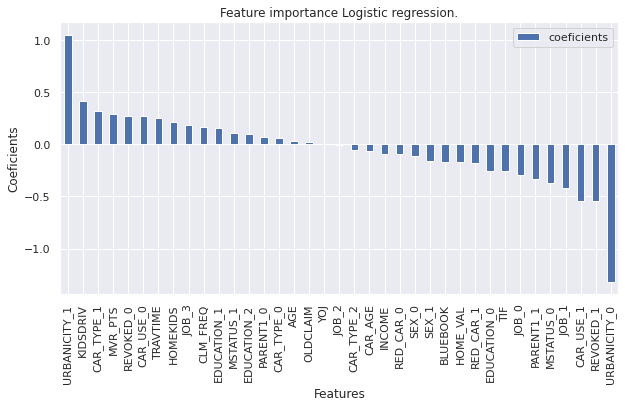

In [40]:
logi_reg_coefficients = pd.DataFrame(logi_reg.coef_[0], index=X_train.columns, columns=["coeficients"])
logi_reg_coefficients.sort_values(by="coeficients", ascending=False).plot.bar(figsize=(10,5))
plt.xlabel("Features")
plt.ylabel("Coeficients")
plt.title("Feature importance Logistic regression.")
plt.show()


Feature importance: XgBoost

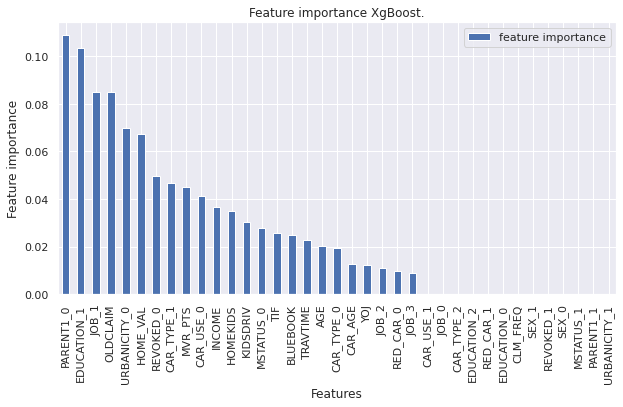

In [41]:
xgb_f_importance = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=["feature importance"])
xgb_f_importance.sort_values(by="feature importance", ascending=False).plot.bar(figsize=(10,5))
plt.xlabel("Features")
plt.ylabel("Feature importance")
plt.title("Feature importance XgBoost.")
plt.show()

The results are different, we will not dig into it cause it is not the goal of this project.

## Predicting the test set with the best model

In order to choose which one to use, we will compare the mean of the metrics in the test sets.

In [42]:
comparison = pd.DataFrame(index=metrics)
logi_reg_comparison = []
for mean, std in zip(logi_reg_metrics["Mean Test"].values, logi_reg_metrics["Std Test"].values): 
  logi_reg_comparison.append(str(round(mean, 3))+ ' +/- '+str(round(std, 3)))

xgb_comparison = []
for mean, std in zip(xgb_metrics["Mean Test"].values, xgb_metrics["Std Test"].values): 
  xgb_comparison.append(str(round(mean, 3))+' +/- '+str(round(std, 3)))

comparison["Logistic Regression"] = logi_reg_comparison
comparison["XgBoost"] = xgb_comparison


print(comparison)

                   Logistic Regression          XgBoost
Precision               0.81 +/- 0.005  0.807 +/- 0.006
Sensitivity/recall     0.924 +/- 0.007  0.948 +/- 0.007
Specificity            0.395 +/- 0.017  0.368 +/- 0.022
F1-Score               0.863 +/- 0.005  0.872 +/- 0.005
Accuracy               0.785 +/- 0.008  0.795 +/- 0.008


Even if the difference is not significant, we will choose the Logistic Regression to predict the test set since it predicts better the monority class than the XgBoost.

In [44]:
y_pred = logi_reg.predict(X_test)
pd.DataFrame(y_pred).to_csv('predictions.csv')

## Conclusion

In this project we explored and transformed the data to get the best of our chosen models. We mentioned the problems of our data and we tried to fix some of them. We observed that the model trained could not predict well the minority class.
Suggestions:


*   It may be benefitial to try a oversampling technique like SMOTE to decrease the diference between the two classes.
*    Other types of encoding and transformation can be applied so we can find which are the best. 
*   With more context of the problem we can extract more useful information.


